In [1]:
# pip install transformers torch pandas scikit-learn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

path = "drive/MyDrive/HealthML/final_project_files/"
df = pd.read_csv(path + "processed_notes.csv")

# Split the data into train, validation, and test sets
train_val, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

# Model Preparation

Load the ClinicalBERT model with a classification head from the Hugging Face transformers library: https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT?text=Paris+is+the+%5BMASK%5D+of+France.

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification, logging
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Suppress info messages from transformers (optional, not necessary)
logging.set_verbosity_warning()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# Load model with a specific configuration for binary classification (I could be wrong here if anyone can check it)
model = BertForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=1, ### SELF - changed to 1
    ignore_mismatched_sizes=True  # This will suppress the warnings about mismatch sizes
)
# model.to(device) ### SELF moved this to next cell to see architecture

# Class for handle tokenization
class NotesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Ensure all sequences are padded to the same length
            truncation=True,  # Ensure that sequences longer than model max are truncated
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, batch_size, max_len=512):
    ds = NotesDataset(
        texts=df.TEXT.to_numpy(),
        labels=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

batch_size = 32
train_data_loader = create_data_loader(train, tokenizer, batch_size)
val_data_loader = create_data_loader(val, tokenizer, batch_size)
test_data_loader = create_data_loader(test, tokenizer, batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [4]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * 10  # 10 is the number of epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    total_batches = len(data_loader)
    # print(total_batches)

    ### TODO: Something may be wrong here
    for step, d in tqdm(enumerate(data_loader), total=len(data_loader), desc="Training", position=0, leave=True):
        # print("step: ", step)
        # print("d: ", d)
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        # print("input_ids: ", input_ids)
        # print("attention_mask: ", attention_mask)
        # print("labels: ", labels)

        model.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # print('outputs: ', outputs)

        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # Print progress every 10 batches (just want to check progres here)
        if (step + 1) % 10 == 0 or step == total_batches - 1:
            print(f'Batch {step + 1}/{total_batches}, Loss: {loss.item():.4f}')

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

# Hyperparameter Tuning - worth it?

---



In [5]:
def evaluate_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

In [6]:
small_train = train.sample(frac=0.1, random_state=42)
small_val = val.sample(frac=0.1, random_state=42)

In [8]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 7.9 MB/s eta 0:00:00


In [9]:
import optuna
from transformers import AdamW, get_scheduler

def objective(trial):
    # Define hyperparameter search space
    learning_rate = trial.suggest_float("lr", 1e-6, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Create dataloaders with the suggested batch size
    train_loader = create_data_loader(small_train, tokenizer, batch_size)
    val_loader = create_data_loader(small_val, tokenizer, batch_size)

    # Initialize model and optimizer
    model = BertForSequenceClassification.from_pretrained(
        "emilyalsentzer/Bio_ClinicalBERT",
        num_labels=1,   ### SELF - changed to 1
        ignore_mismatched_sizes=True
    ).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,  # You can adjust this if needed
        num_training_steps=len(train_loader) * 10  # Assuming 10 epochs
    )

    # Train for 1 epoch to validate performance
    train_acc, train_loss = train_epoch(
        model, train_loader, optimizer, device, scheduler, len(small_train)
    )
    val_acc, val_loss = evaluate_model(
        model, val_loader, device, len(small_val)
    )

    return val_loss  # Minimize validation loss

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)

[I 2024-12-06 22:02:18,690] A new study created in memory with name: no-name-6766b70c-2bb0-4a7b-8c36-272c5e9637a6
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   7%|▋         | 10/143 [00:07<01:21,  1.63it/s]

Batch 10/143, Loss: 0.5624


Training:  14%|█▍        | 20/143 [00:13<01:12,  1.70it/s]

Batch 20/143, Loss: 0.6693


Training:  21%|██        | 30/143 [00:19<01:07,  1.68it/s]

Batch 30/143, Loss: 0.4764


Training:  28%|██▊       | 40/143 [00:25<01:00,  1.71it/s]

Batch 40/143, Loss: 0.5303


Training:  35%|███▍      | 50/143 [00:31<00:54,  1.71it/s]

Batch 50/143, Loss: 0.4456


Training:  42%|████▏     | 60/143 [00:37<00:48,  1.71it/s]

Batch 60/143, Loss: 0.3536


Training:  49%|████▉     | 70/143 [00:43<00:42,  1.71it/s]

Batch 70/143, Loss: 0.4892


Training:  56%|█████▌    | 80/143 [00:49<00:36,  1.71it/s]

Batch 80/143, Loss: 0.5948


Training:  63%|██████▎   | 90/143 [00:54<00:31,  1.71it/s]

Batch 90/143, Loss: 0.3852


Training:  70%|██████▉   | 100/143 [01:00<00:25,  1.71it/s]

Batch 100/143, Loss: 0.3581


Training:  77%|███████▋  | 110/143 [01:06<00:19,  1.71it/s]

Batch 110/143, Loss: 0.4894


Training:  84%|████████▍ | 120/143 [01:12<00:13,  1.70it/s]

Batch 120/143, Loss: 0.4188


Training:  91%|█████████ | 130/143 [01:18<00:07,  1.70it/s]

Batch 130/143, Loss: 0.5161


Training:  98%|█████████▊| 140/143 [01:24<00:01,  1.71it/s]

Batch 140/143, Loss: 0.3109


Training: 100%|██████████| 143/143 [01:25<00:00,  1.67it/s]

Batch 143/143, Loss: 0.6655



[I 2024-12-06 22:03:49,468] Trial 0 finished with value: 0.42893267050385475 and parameters: {'lr': 4.9238754777026875e-05, 'batch_size': 32, 'max_len': 512, 'weight_decay': 0.08253680522282106}. Best is trial 0 with value: 0.42893267050385475.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  14%|█▍        | 10/72 [00:11<01:10,  1.14s/it]

Batch 10/72, Loss: 0.6666


Training:  28%|██▊       | 20/72 [00:23<00:59,  1.14s/it]

Batch 20/72, Loss: 0.6362


Training:  42%|████▏     | 30/72 [00:34<00:47,  1.14s/it]

Batch 30/72, Loss: 0.5582


Training:  56%|█████▌    | 40/72 [00:45<00:36,  1.14s/it]

Batch 40/72, Loss: 0.6373


Training:  69%|██████▉   | 50/72 [00:57<00:25,  1.14s/it]

Batch 50/72, Loss: 0.5587


Training:  83%|████████▎ | 60/72 [01:08<00:13,  1.14s/it]

Batch 60/72, Loss: 0.6015


Training:  97%|█████████▋| 70/72 [01:20<00:02,  1.14s/it]

Batch 70/72, Loss: 0.6380


Training: 100%|██████████| 72/72 [01:21<00:00,  1.13s/it]

Batch 72/72, Loss: 0.7307



[I 2024-12-06 22:05:16,309] Trial 1 finished with value: 0.5651077441871166 and parameters: {'lr': 1.0468750264505716e-05, 'batch_size': 64, 'max_len': 512, 'weight_decay': 0.008535216917107069}. Best is trial 0 with value: 0.42893267050385475.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  14%|█▍        | 10/72 [00:11<01:10,  1.14s/it]

Batch 10/72, Loss: 0.6667


Training:  28%|██▊       | 20/72 [00:23<00:59,  1.14s/it]

Batch 20/72, Loss: 0.6486


Training:  42%|████▏     | 30/72 [00:34<00:47,  1.14s/it]

Batch 30/72, Loss: 0.5897


Training:  56%|█████▌    | 40/72 [00:46<00:36,  1.14s/it]

Batch 40/72, Loss: 0.6682


Training:  69%|██████▉   | 50/72 [00:57<00:25,  1.14s/it]

Batch 50/72, Loss: 0.5735


Training:  83%|████████▎ | 60/72 [01:08<00:13,  1.14s/it]

Batch 60/72, Loss: 0.6305


Training:  97%|█████████▋| 70/72 [01:20<00:02,  1.14s/it]

Batch 70/72, Loss: 0.6002


Training: 100%|██████████| 72/72 [01:21<00:00,  1.13s/it]

Batch 72/72, Loss: 0.7634



[I 2024-12-06 22:06:43,093] Trial 2 finished with value: 0.576123371720314 and parameters: {'lr': 7.4215890658900926e-06, 'batch_size': 64, 'max_len': 512, 'weight_decay': 0.025767560701000114}. Best is trial 0 with value: 0.42893267050385475.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  14%|█▍        | 10/72 [00:05<00:34,  1.79it/s]

Batch 10/72, Loss: 0.7270


Training:  28%|██▊       | 20/72 [00:11<00:28,  1.80it/s]

Batch 20/72, Loss: 0.6773


Training:  31%|███       | 22/72 [00:12<00:29,  1.70it/s]
[W 2024-12-06 22:06:58,189] Trial 3 failed with parameters: {'lr': 2.1279522215922493e-06, 'batch_size': 64, 'max_len': 256, 'weight_decay': 0.06818520989149478} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-9-ef39361c3eb2>", line 30, in objective
    train_acc, train_loss = train_epoch(
  File "<ipython-input-4-389edada3ddd>", line 52, in train_epoch
    optimizer.step()
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py", line 137, in wrapper
    return func.__get__(opt, opt.__class__)(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/optimizer.py", line 487, in wrapper
    out = func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", lin

KeyboardInterrupt: 

# Training

In [ ]:
import os

# Define a directory to save checkpoints
checkpoint_dir = "drive/MyDrive/HealthML/final_project/checkpoints"  # Adjust the path
os.makedirs(checkpoint_dir, exist_ok=True) # Create directory if it doesn't exist

In [6]:
for epoch in tqdm(range(10)):
    print(f'Epoch {epoch + 1}')
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(train)  # Make sure 'train' contains the correct number of samples
    )
    print(f'Train loss {train_loss:.4f}, Accuracy {train_acc:.4f}')

    checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, checkpoint_path)
    print(f'Checkpoint saved to {checkpoint_path}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


Training:   8%|▊         | 10/125 [00:07<01:22,  1.39it/s]

Batch 10/125, Loss: 0.5703


Training:  16%|█▌        | 20/125 [00:13<01:12,  1.44it/s]

Batch 20/125, Loss: 0.6686


Training:  24%|██▍       | 30/125 [00:19<01:05,  1.44it/s]

Batch 30/125, Loss: 0.5393


Training:  32%|███▏      | 40/125 [00:25<00:59,  1.44it/s]

Batch 40/125, Loss: 0.5454


Training:  40%|████      | 50/125 [00:31<00:52,  1.44it/s]

Batch 50/125, Loss: 0.4944


Training:  48%|████▊     | 60/125 [00:37<00:45,  1.44it/s]

Batch 60/125, Loss: 0.4782


Training:  56%|█████▌    | 70/125 [00:43<00:38,  1.44it/s]

Batch 70/125, Loss: 0.6412


Training:  64%|██████▍   | 80/125 [00:48<00:31,  1.44it/s]

Batch 80/125, Loss: 0.6360


Training:  72%|███████▏  | 90/125 [00:54<00:24,  1.44it/s]

Batch 90/125, Loss: 0.4479


Training:  80%|████████  | 100/125 [01:00<00:17,  1.44it/s]

Batch 100/125, Loss: 0.4086


Training:  88%|████████▊ | 110/125 [01:06<00:10,  1.44it/s]

Batch 110/125, Loss: 0.5162


Training:  96%|█████████▌| 120/125 [01:12<00:03,  1.44it/s]

Batch 120/125, Loss: 0.4801


 10%|█         | 1/10 [01:15<11:16, 75.22s/it]

Batch 125/125, Loss: 0.4483
Train loss 0.5750, Accuracy 0.0617
Epoch 2


Training:   8%|▊         | 10/125 [00:06<01:20,  1.43it/s]

Batch 10/125, Loss: 0.3734


Training:  16%|█▌        | 20/125 [00:11<01:12,  1.44it/s]

Batch 20/125, Loss: 0.4332


Training:  24%|██▍       | 30/125 [00:17<01:05,  1.44it/s]

Batch 30/125, Loss: 0.3563


Training:  32%|███▏      | 40/125 [00:23<00:58,  1.44it/s]

Batch 40/125, Loss: 0.3394


Training:  40%|████      | 50/125 [00:29<00:52,  1.44it/s]

Batch 50/125, Loss: 0.3979


Training:  48%|████▊     | 60/125 [00:35<00:45,  1.44it/s]

Batch 60/125, Loss: 0.3397


Training:  56%|█████▌    | 70/125 [00:41<00:38,  1.44it/s]

Batch 70/125, Loss: 0.3655


Training:  64%|██████▍   | 80/125 [00:46<00:31,  1.44it/s]

Batch 80/125, Loss: 0.4175


Training:  72%|███████▏  | 90/125 [00:52<00:24,  1.44it/s]

Batch 90/125, Loss: 0.2337


Training:  80%|████████  | 100/125 [00:58<00:17,  1.44it/s]

Batch 100/125, Loss: 0.3206


Training:  88%|████████▊ | 110/125 [01:04<00:10,  1.44it/s]

Batch 110/125, Loss: 0.4782


Training:  96%|█████████▌| 120/125 [01:10<00:03,  1.44it/s]

Batch 120/125, Loss: 0.3895


 20%|██        | 2/10 [02:28<09:52, 74.03s/it]

Batch 125/125, Loss: 0.3742
Train loss 0.4448, Accuracy 0.0695
Epoch 3


Training:   8%|▊         | 10/125 [00:06<01:20,  1.44it/s]

Batch 10/125, Loss: 0.2785


Training:  16%|█▌        | 20/125 [00:11<01:12,  1.44it/s]

Batch 20/125, Loss: 0.3661


Training:  24%|██▍       | 30/125 [00:17<01:06,  1.43it/s]

Batch 30/125, Loss: 0.2713


Training:  32%|███▏      | 40/125 [00:23<00:58,  1.44it/s]

Batch 40/125, Loss: 0.1895


Training:  40%|████      | 50/125 [00:29<00:51,  1.44it/s]

Batch 50/125, Loss: 0.3622


Training:  48%|████▊     | 60/125 [00:35<00:45,  1.44it/s]

Batch 60/125, Loss: 0.2264


Training:  56%|█████▌    | 70/125 [00:41<00:38,  1.44it/s]

Batch 70/125, Loss: 0.2334


Training:  64%|██████▍   | 80/125 [00:46<00:31,  1.44it/s]

Batch 80/125, Loss: 0.3141


Training:  72%|███████▏  | 90/125 [00:52<00:24,  1.44it/s]

Batch 90/125, Loss: 0.1624


Training:  80%|████████  | 100/125 [00:58<00:17,  1.44it/s]

Batch 100/125, Loss: 0.2589


Training:  88%|████████▊ | 110/125 [01:04<00:10,  1.44it/s]

Batch 110/125, Loss: 0.4117


Training:  96%|█████████▌| 120/125 [01:10<00:03,  1.44it/s]

Batch 120/125, Loss: 0.3888


 30%|███       | 3/10 [03:41<08:35, 73.66s/it]

Batch 125/125, Loss: 0.2858
Train loss 0.3454, Accuracy 0.0742
Epoch 4


Training:   8%|▊         | 10/125 [00:06<01:20,  1.44it/s]

Batch 10/125, Loss: 0.1967


Training:  16%|█▌        | 20/125 [00:11<01:12,  1.44it/s]

Batch 20/125, Loss: 0.3053


Training:  24%|██▍       | 30/125 [00:17<01:05,  1.44it/s]

Batch 30/125, Loss: 0.2213


Training:  32%|███▏      | 40/125 [00:23<00:58,  1.44it/s]

Batch 40/125, Loss: 0.1384


Training:  40%|████      | 50/125 [00:29<00:51,  1.44it/s]

Batch 50/125, Loss: 0.3561


Training:  48%|████▊     | 60/125 [00:35<00:45,  1.44it/s]

Batch 60/125, Loss: 0.1585


Training:  56%|█████▌    | 70/125 [00:41<00:38,  1.44it/s]

Batch 70/125, Loss: 0.1321


Training:  64%|██████▍   | 80/125 [00:46<00:31,  1.44it/s]

Batch 80/125, Loss: 0.2302


Training:  72%|███████▏  | 90/125 [00:52<00:24,  1.44it/s]

Batch 90/125, Loss: 0.1181


Training:  80%|████████  | 100/125 [00:58<00:17,  1.44it/s]

Batch 100/125, Loss: 0.1738


Training:  88%|████████▊ | 110/125 [01:04<00:10,  1.44it/s]

Batch 110/125, Loss: 0.2773


Training:  96%|█████████▌| 120/125 [01:10<00:03,  1.44it/s]

Batch 120/125, Loss: 0.1964


 40%|████      | 4/10 [04:54<07:20, 73.46s/it]

Batch 125/125, Loss: 0.1924
Train loss 0.2561, Accuracy 0.0785
Epoch 5


Training:   8%|▊         | 10/125 [00:06<01:20,  1.44it/s]

Batch 10/125, Loss: 0.1051


Training:  16%|█▌        | 20/125 [00:11<01:12,  1.44it/s]

Batch 20/125, Loss: 0.1703


Training:  24%|██▍       | 30/125 [00:17<01:05,  1.44it/s]

Batch 30/125, Loss: 0.1284


Training:  32%|███▏      | 40/125 [00:23<00:58,  1.44it/s]

Batch 40/125, Loss: 0.0811


Training:  40%|████      | 50/125 [00:29<00:51,  1.44it/s]

Batch 50/125, Loss: 0.2873


Training:  48%|████▊     | 60/125 [00:35<00:45,  1.44it/s]

Batch 60/125, Loss: 0.0988


Training:  56%|█████▌    | 70/125 [00:41<00:38,  1.44it/s]

Batch 70/125, Loss: 0.0908


Training:  64%|██████▍   | 80/125 [00:46<00:31,  1.44it/s]

Batch 80/125, Loss: 0.0837


Training:  72%|███████▏  | 90/125 [00:52<00:24,  1.44it/s]

Batch 90/125, Loss: 0.0627


Training:  80%|████████  | 100/125 [00:58<00:17,  1.44it/s]

Batch 100/125, Loss: 0.0608


Training:  88%|████████▊ | 110/125 [01:04<00:10,  1.44it/s]

Batch 110/125, Loss: 0.2557


Training:  96%|█████████▌| 120/125 [01:10<00:03,  1.44it/s]

Batch 120/125, Loss: 0.1263


 50%|█████     | 5/10 [06:07<06:06, 73.36s/it]

Batch 125/125, Loss: 0.1751
Train loss 0.1878, Accuracy 0.0814
Epoch 6


Training:   8%|▊         | 10/125 [00:06<01:20,  1.44it/s]

Batch 10/125, Loss: 0.0620


Training:  16%|█▌        | 20/125 [00:11<01:12,  1.44it/s]

Batch 20/125, Loss: 0.1266


Training:  24%|██▍       | 30/125 [00:17<01:05,  1.44it/s]

Batch 30/125, Loss: 0.0168


Training:  32%|███▏      | 40/125 [00:23<00:58,  1.44it/s]

Batch 40/125, Loss: 0.0617


Training:  40%|████      | 50/125 [00:29<00:51,  1.44it/s]

Batch 50/125, Loss: 0.2553


Training:  48%|████▊     | 60/125 [00:35<00:45,  1.44it/s]

Batch 60/125, Loss: 0.0187


Training:  56%|█████▌    | 70/125 [00:41<00:38,  1.44it/s]

Batch 70/125, Loss: 0.0668


Training:  64%|██████▍   | 80/125 [00:46<00:31,  1.45it/s]

Batch 80/125, Loss: 0.2726


Training:  72%|███████▏  | 90/125 [00:52<00:24,  1.44it/s]

Batch 90/125, Loss: 0.0265


Training:  80%|████████  | 100/125 [00:58<00:17,  1.44it/s]

Batch 100/125, Loss: 0.0361


Training:  88%|████████▊ | 110/125 [01:04<00:10,  1.44it/s]

Batch 110/125, Loss: 0.0654


Training:  96%|█████████▌| 120/125 [01:10<00:03,  1.44it/s]

Batch 120/125, Loss: 0.0824


 60%|██████    | 6/10 [07:21<04:53, 73.29s/it]

Batch 125/125, Loss: 0.0724
Train loss 0.1292, Accuracy 0.0839
Epoch 7


Training:   8%|▊         | 10/125 [00:06<01:20,  1.44it/s]

Batch 10/125, Loss: 0.0256


Training:  16%|█▌        | 20/125 [00:11<01:12,  1.44it/s]

Batch 20/125, Loss: 0.0263


Training:  24%|██▍       | 30/125 [00:17<01:05,  1.44it/s]

Batch 30/125, Loss: 0.0063


Training:  32%|███▏      | 40/125 [00:23<00:58,  1.44it/s]

Batch 40/125, Loss: 0.0599


Training:  40%|████      | 50/125 [00:29<00:51,  1.44it/s]

Batch 50/125, Loss: 0.1486


Training:  48%|████▊     | 60/125 [00:35<00:45,  1.44it/s]

Batch 60/125, Loss: 0.0157


Training:  56%|█████▌    | 70/125 [00:41<00:38,  1.44it/s]

Batch 70/125, Loss: 0.0975


Training:  64%|██████▍   | 80/125 [00:46<00:31,  1.44it/s]

Batch 80/125, Loss: 0.0205


Training:  72%|███████▏  | 90/125 [00:52<00:24,  1.44it/s]

Batch 90/125, Loss: 0.0066


Training:  80%|████████  | 100/125 [00:58<00:17,  1.44it/s]

Batch 100/125, Loss: 0.0075


Training:  88%|████████▊ | 110/125 [01:04<00:10,  1.44it/s]

Batch 110/125, Loss: 0.1822


Training:  96%|█████████▌| 120/125 [01:10<00:03,  1.44it/s]

Batch 120/125, Loss: 0.0311


 70%|███████   | 7/10 [08:34<03:39, 73.26s/it]

Batch 125/125, Loss: 0.0582
Train loss 0.0905, Accuracy 0.0850
Epoch 8


Training:   8%|▊         | 10/125 [00:06<01:20,  1.44it/s]

Batch 10/125, Loss: 0.0175


Training:  16%|█▌        | 20/125 [00:11<01:12,  1.44it/s]

Batch 20/125, Loss: 0.0241


Training:  24%|██▍       | 30/125 [00:17<01:05,  1.44it/s]

Batch 30/125, Loss: 0.0188


Training:  32%|███▏      | 40/125 [00:23<00:59,  1.44it/s]

Batch 40/125, Loss: 0.0560


Training:  40%|████      | 50/125 [00:29<00:51,  1.44it/s]

Batch 50/125, Loss: 0.0725


Training:  48%|████▊     | 60/125 [00:35<00:45,  1.44it/s]

Batch 60/125, Loss: 0.0230


Training:  56%|█████▌    | 70/125 [00:41<00:38,  1.44it/s]

Batch 70/125, Loss: 0.0234


Training:  64%|██████▍   | 80/125 [00:46<00:31,  1.44it/s]

Batch 80/125, Loss: 0.0512


Training:  72%|███████▏  | 90/125 [00:52<00:24,  1.44it/s]

Batch 90/125, Loss: 0.0495


Training:  80%|████████  | 100/125 [00:58<00:17,  1.44it/s]

Batch 100/125, Loss: 0.0046


Training:  88%|████████▊ | 110/125 [01:04<00:10,  1.44it/s]

Batch 110/125, Loss: 0.0194


Training:  96%|█████████▌| 120/125 [01:10<00:03,  1.44it/s]

Batch 120/125, Loss: 0.0378


 80%|████████  | 8/10 [09:47<02:26, 73.25s/it]

Batch 125/125, Loss: 0.0770
Train loss 0.0664, Accuracy 0.0859
Epoch 9


Training:   8%|▊         | 10/125 [00:06<01:20,  1.44it/s]

Batch 10/125, Loss: 0.0095


Training:  16%|█▌        | 20/125 [00:11<01:12,  1.44it/s]

Batch 20/125, Loss: 0.0113


Training:  24%|██▍       | 30/125 [00:17<01:05,  1.44it/s]

Batch 30/125, Loss: 0.0025


Training:  32%|███▏      | 40/125 [00:23<00:58,  1.44it/s]

Batch 40/125, Loss: 0.0659


Training:  40%|████      | 50/125 [00:29<00:51,  1.44it/s]

Batch 50/125, Loss: 0.1372


Training:  48%|████▊     | 60/125 [00:35<00:45,  1.44it/s]

Batch 60/125, Loss: 0.0027


Training:  56%|█████▌    | 70/125 [00:41<00:38,  1.44it/s]

Batch 70/125, Loss: 0.0394


Training:  64%|██████▍   | 80/125 [00:46<00:31,  1.44it/s]

Batch 80/125, Loss: 0.0795


Training:  72%|███████▏  | 90/125 [00:52<00:24,  1.44it/s]

Batch 90/125, Loss: 0.0021


Training:  80%|████████  | 100/125 [00:58<00:17,  1.44it/s]

Batch 100/125, Loss: 0.0026


Training:  88%|████████▊ | 110/125 [01:04<00:10,  1.44it/s]

Batch 110/125, Loss: 0.1312


Training:  96%|█████████▌| 120/125 [01:10<00:03,  1.44it/s]

Batch 120/125, Loss: 0.0498


 90%|█████████ | 9/10 [11:00<01:13, 73.23s/it]

Batch 125/125, Loss: 0.1220
Train loss 0.0531, Accuracy 0.0864
Epoch 10


Training:   8%|▊         | 10/125 [00:06<01:20,  1.44it/s]

Batch 10/125, Loss: 0.0036


Training:  16%|█▌        | 20/125 [00:11<01:12,  1.44it/s]

Batch 20/125, Loss: 0.0225


Training:  24%|██▍       | 30/125 [00:17<01:05,  1.44it/s]

Batch 30/125, Loss: 0.0016


Training:  32%|███▏      | 40/125 [00:23<00:58,  1.44it/s]

Batch 40/125, Loss: 0.0413


Training:  40%|████      | 50/125 [00:29<00:51,  1.44it/s]

Batch 50/125, Loss: 0.0590


Training:  48%|████▊     | 60/125 [00:35<00:45,  1.44it/s]

Batch 60/125, Loss: 0.0017


Training:  56%|█████▌    | 70/125 [00:41<00:38,  1.44it/s]

Batch 70/125, Loss: 0.0121


Training:  64%|██████▍   | 80/125 [00:46<00:31,  1.44it/s]

Batch 80/125, Loss: 0.0273


Training:  72%|███████▏  | 90/125 [00:52<00:24,  1.44it/s]

Batch 90/125, Loss: 0.0016


Training:  80%|████████  | 100/125 [00:58<00:17,  1.44it/s]

Batch 100/125, Loss: 0.0165


Training:  88%|████████▊ | 110/125 [01:04<00:10,  1.44it/s]

Batch 110/125, Loss: 0.0742


Training:  96%|█████████▌| 120/125 [01:10<00:03,  1.44it/s]

Batch 120/125, Loss: 0.0183


100%|██████████| 10/10 [12:13<00:00, 73.39s/it]

Batch 125/125, Loss: 0.0091
Train loss 0.0468, Accuracy 0.0868


# Model Evaluation - just quickly made these blocks with LLM to test smaller model, have to revise and implement voting by following readmission notebook

In [7]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()  # Set the model to evaluation mode
    losses = []
    correct_predictions = 0

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

In [8]:
# Evaluate on the validation set
val_acc, val_loss = eval_model(model, val_data_loader, device, len(val))
print(f'Val loss {val_loss:.4f}, Accuracy {val_acc:.4f}')

# Evaluate on the test set
test_acc, test_loss = eval_model(model, test_data_loader, device, len(test))
print(f'Test loss {test_loss:.4f}, Accuracy {test_acc:.4f}')

Val loss 1.0224, Accuracy 0.7755
Test loss 1.0415, Accuracy 0.7730


In [14]:
from sklearn.metrics import roc_curve, auc

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Get predicted probabilities for class 1
            probs = torch.softmax(outputs.logits, dim=1)[:, 1]

            predictions.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Get predictions for the validation set (or test set)
val_predictions, val_true_labels = get_predictions(model, val_data_loader, device)

In [10]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(val_true_labels, val_predictions)
roc_auc = auc(fpr, tpr)

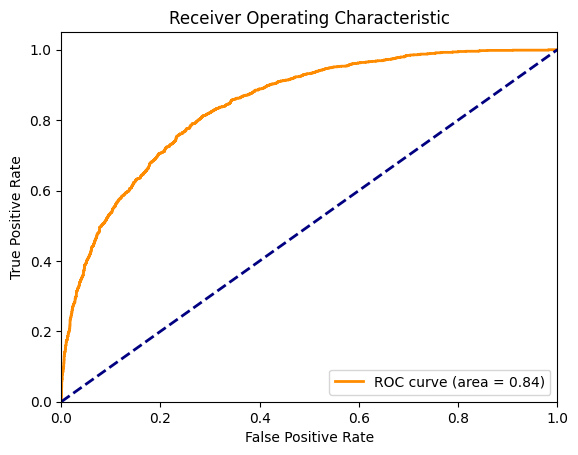

In [11]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()